In [2]:
import os, sys

import copy
import caffe
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import reduce
from collections import OrderedDict
from IPython.display import display, Image
from PIL.Image import open as IMG_OPEN
caffe.set_mode_gpu()
caffe.set_device(2)

import warnings
warnings.filterwarnings('ignore')

In [3]:
anno = {  
    '行人类型' : ['其他', '单人全身', '单人上半身', '单人下半身', '多人', '骑车人'],
    '种族类型' :['未知','黄种人','白人','黑人',], 
    '性别':  [ '未知','男','女',],  
    '年龄类型': ['未知', '未成年','青年','中年','老年',],  
    '发型'    : ['未知','短发','长发','其他'], 
    '帽子类型' :['未知', '其他帽','未戴帽','鸭舌帽','安全帽'],   
    '背包类型': ['未知', '其他包','未背包','单肩包','双肩包','手提包',], 
    '上衣类型' :['未知','其他','长袖','短袖',], 
    '上衣颜色' :['未知','多色','白','黑','蓝','红','黄','灰','紫','橙','绿','棕'],   
    '裤子类型': ['未知','其他','长裤','短裤','裙子'],
    '裤子颜色': ['未知','多色','白','黑','蓝','红','黄','灰','紫','橙','绿','棕'], 
    '上衣纹理':[ '未知', '格子', '条纹', '纯色(logo)', '多色拼接',],
    '朝向':['未知','朝前', '朝后', '侧面', ],
    '打伞':[ '未知','打伞', '未打伞',],
    '拎东西' : ['未知','拎东西', '未拎东西', ],
    '口罩': ['未知','戴口罩', '未戴口罩', ],
    '眼镜': ['未知', '戴眼镜', '未戴眼镜',],
    '拉杆箱':['未知','有', '无', ],
    '手推车':['未知','有', '无', ],
    '抱小孩':['未知','有', '无', ]
}
anno_old = {
    '年龄类型': ['未成年','青年','中年','老年','未知'],
    '背包类型': ['未背包','单肩包','双肩包','手提包','未知'],
    '上衣颜色' :['白','黑','红','黄','蓝','绿','紫','棕','灰','橙','未知',],
    '上衣类型' :['长袖','短袖','未知',],
    '发型'    : ['长发','短发','未知',],
    '帽子类型' :['未戴帽','鸭舌帽','其他帽','未知',],
    '种族类型' :['黄种人','白人','黑人','未知',],
    '性别':   [ '男','女','未知',],
    '裤子颜色': ['白','黑','红','黄','蓝','绿','紫','棕','灰','橙','未知',],
    '裤子类型': ['长裤','短裤','未知'],
}

label = ['行人类型', '种族类型', '性别', '年龄类型', '发型', '帽子类型', '背包类型',
        '上衣类型', '上衣颜色', '裤子类型', '裤子颜色', '上衣纹理', '朝向', '打伞', 
        '拎东西', '口罩', '眼镜', '拉杆箱', '手推车', '抱小孩']
anno = OrderedDict(anno)

In [18]:
num = pd.DataFrame()
for i, k in enumerate(label):
    num[i+1] = [k, len(anno[k])]
num

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,行人类型,种族类型,性别,年龄类型,发型,帽子类型,背包类型,上衣类型,上衣颜色,裤子类型,裤子颜色,上衣纹理,朝向,打伞,拎东西,口罩,眼镜,拉杆箱,手推车,抱小孩
1,6,4,3,5,4,5,6,4,12,5,12,5,4,3,3,3,3,3,3,3


In [5]:
def cat_dict(aim):
    im_path = [list(i.keys())[0] for i in aim]
    values = [list(i.values())[0] for i in aim]
    ret_dict = {}
    ret_dict['im_path'] = im_path
    func_cat = lambda b,c : { key: np.concatenate((b[key], c[key])).tolist()  for key in b }
    ret_dict['prob_list'] = reduce(func_cat, values)
    return ret_dict

def get_img_list(path):
    is_image_file = lambda x : any(x.endswith(extension) 
                                   for extension in ['.jpg',])
    return [os.path.join(path, x) for x in os.listdir(path) if is_image_file(x)]

def get_gt(a, b):
    t = copy.deepcopy(a)
    for j in a.columns:
        t[j] = a[j] == b[j]
    return t

def cover_mean_file(mean_proto_path, mean_npy_path):
    blob = caffe.proto.caffe_pb2.BlobProto()           # 创建protobuf blob
    data = open(mean_proto_path, 'rb' ).read()         # 读入mean.binaryproto文件内容
    blob.ParseFromString(data)                         # 解析文件内容到blob

    array = np.array(caffe.io.blobproto_to_array(blob))# 将blob中的均值转换成numpy格式，array的shape （mean_number，channel, hight, width）
    mean_npy = array[0]                                # 一个array中可以有多组均值存在，故需要通过下标选择其中一组均值
    np.save(mean_npy_path ,mean_npy)

def deal_col(x):
    return label[int(x.split('_')[0].lstrip('prob'))-1]


In [6]:
# 待转换的pb格式图像均值文件路径
mean_proto_path = 'lmdb_data/img_train_lmdb/mean.binaryproto'
# 转换后的numpy格式图像均值文件路径
mean_npy_path = 'lmdb_data/img_train_lmdb/mean.npy'
# Deploy_file
deploy_file_path = 'deploy.prototxt'


# Model
model_path_1 = 'pretraind/resnet-18_iter_222667.caffemodel'
model_path_2 = 'snapshot/resnet18_jilin_iter_10000.caffemodel'
model_path_3 = 'snapshot/resnet18_jilin_iter_347638.caffemodel'


test_img_paths = 'dataset/jilin_test'

att_probs = []
cover_mean_file(mean_proto_path, mean_npy_path)
temps = []

In [7]:
class CaffeNet():
    
    def __init__(self, deploy_file_path, model_path, mean_npy_path):
        self.net = caffe.Net(deploy_file_path, 
                caffe.TEST, 
                weights=model_path)
        self.to_transform(mean_npy_path)
        self.to_reshape()
        
    def to_transform(self, mean_npy_path):
        # 得到data的形状，这里的图片是默认matplotlib底层加载的
        self.transform=caffe.io.Transformer({'data':self.net.blobs['data'].data.shape})
        # image是像素[0-1],图片的数据格式[weight,high,channels]，RGB
        self.transform.set_transpose('data',(2,0,1))
        # 归一化
        self.transform.set_mean('data', np.load(mean_npy_path).mean(1).mean(1))
        # 图片像素放大到[0-255]
        self.transform.set_raw_scale('data',255)
        # RGB-->BGR 转换
        self.transform.set_channel_swap('data',(2,1,0))
        
    def to_reshape(self):
        self.net.blobs['data'].reshape(1,3,224,224)
        
    def infer_one_image(self, img_path):
        image=caffe.io.load_image(img_path)
        transformed_image = self.transform.preprocess('data', image)
        self.net.blobs['data'].data[...] = transformed_image
        temps.append(transformed_image.flatten())
        output = self.net.forward()
        return {img_path: output}
    
    def infer_im_list(self, im_list_paths):
        dict_list = []
        # for im_path in tqdm(im_list_paths, desc='Extract Feature', miniters=20, ncols=120, unit=' images'):
        for im_path in im_list_paths:
            feat_dict = self.infer_one_image(im_path)
            # print(feat_dict)
            dict_list.append(copy.deepcopy(feat_dict))
           
        dict_list = cat_dict(dict_list)
        return dict_list

In [6]:
caffe_net1 = CaffeNet(mean_npy_path=mean_npy_path,
                    deploy_file_path = deploy_file_path,
                    model_path= model_path_1)
caffe_net2 = CaffeNet(mean_npy_path=mean_npy_path,
                    deploy_file_path = deploy_file_path,
                    model_path= model_path_2)
caffe_net3 = CaffeNet(mean_npy_path=mean_npy_path,
                    deploy_file_path = deploy_file_path,
                    model_path= model_path_3)
temp_path = '../model_backup/Beta1_pur_person/'


# # 待转换的pb格式图像均值文件路径
# mean_proto_path_ = temp_path + 'mean.binaryproto'
# # 转换后的numpy格式图像均值文件路径
# mean_npy_path_ = temp_path + 'mean.npy'
# # Deploy_file
# deploy_file_path_ = temp_path + 'deploy.prototxt'
# # Model
# model_path_ = temp_path + 'resnet-18_iter_580000.caffemodel'
# cover_mean_file(mean_proto_path_, mean_npy_path_)
# caffe_net4 = CaffeNet(mean_npy_path=mean_npy_path_,
#                     deploy_file_path = deploy_file_path_,
#                     model_path= model_path_)

In [7]:
test_img_paths = '8'

In [8]:
for caffe_net in (caffe_net1, caffe_net2, caffe_net3, ):
    test_img_list= get_img_list(test_img_paths)
    model_feat = caffe_net.infer_im_list(test_img_list)
    att_prob = pd.DataFrame(model_feat['prob_list'], index=model_feat['im_path'])
    att_prob = att_prob.applymap(lambda x:x.index(max(x))).sort_index(axis=0)
    att_prob.columns = pd.Series(att_prob.columns).apply(deal_col)

    for att in att_prob:
        annotation = anno[att]
        prob = att_prob[att]
        att_prob[att] = prob.apply(lambda x: annotation[x])

    att_probs.append(att_prob)

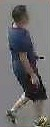

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


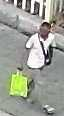

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未知,未知
拉杆箱,无,无,无


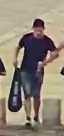

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,裙子,裙子,裙子
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未知,未知,未知
眼镜,未知,未知,未知
拉杆箱,无,无,无


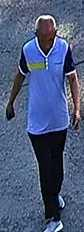

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


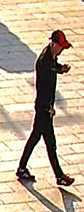

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


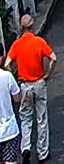

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,灰,灰,灰
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,戴眼镜,未戴眼镜
拉杆箱,无,无,无


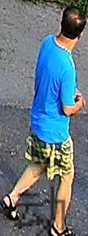

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未知,戴眼镜,戴眼镜
拉杆箱,无,无,无


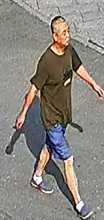

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


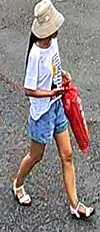

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未知
拉杆箱,无,无,无


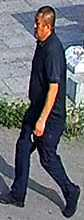

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


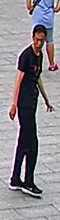

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


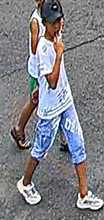

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未知,未知,未知
眼镜,未知,未知,未知
拉杆箱,无,无,无


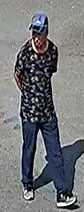

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未知,未知,未知
眼镜,未知,未知,未知
拉杆箱,无,无,无


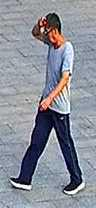

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未知,未知
眼镜,未知,未知,未知
拉杆箱,无,无,无


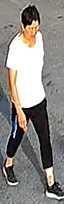

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


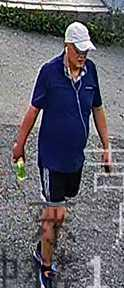

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


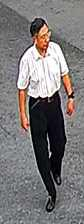

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


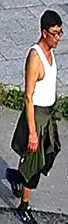

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,裙子,裙子,裙子
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


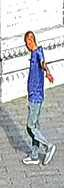

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,灰
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


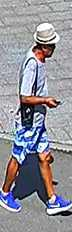

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,绿
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


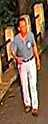

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,白,白,白
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


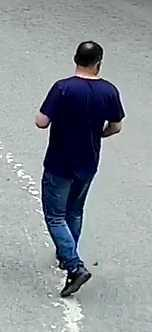

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未知,未知,未知
眼镜,未知,未知,未知
拉杆箱,无,无,无


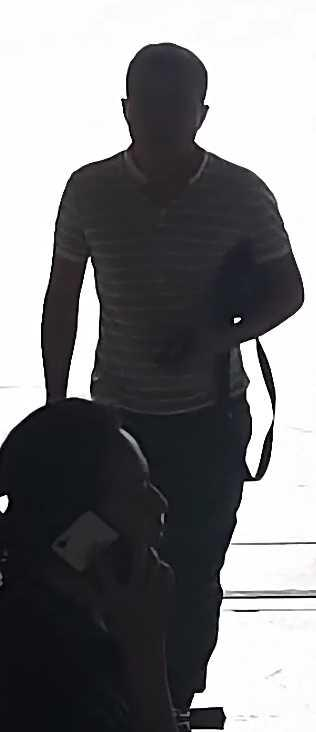

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


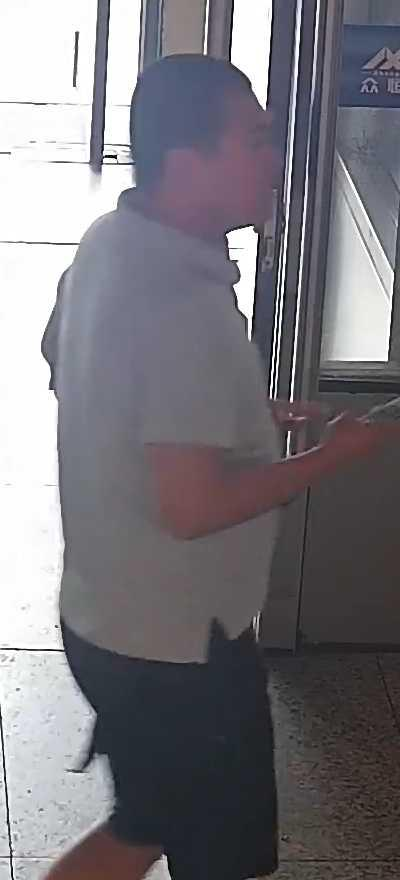

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,朝后,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未知,未知,未知
拉杆箱,无,无,无


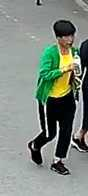

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


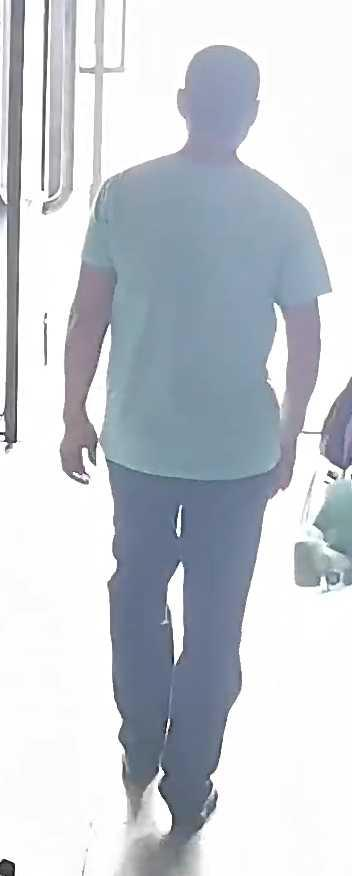

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


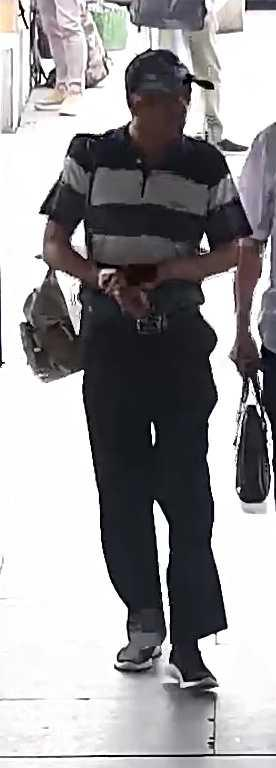

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未知,未知
拉杆箱,无,无,无


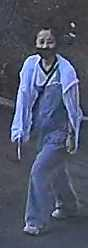

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


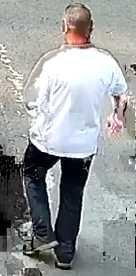

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


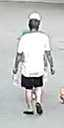

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


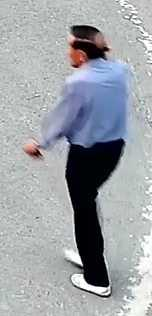

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


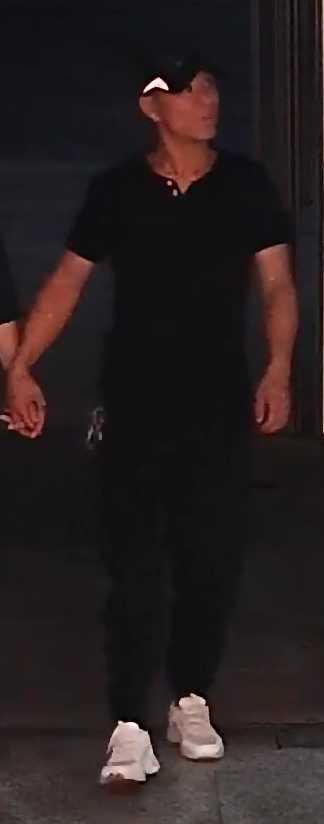

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


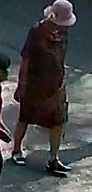

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,裙子,裙子,裙子
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


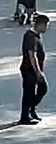

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,条纹,条纹,纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


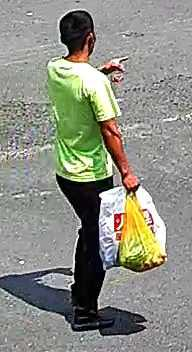

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


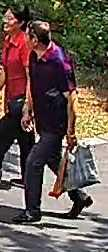

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未知,未知
眼镜,未知,未知,未知
拉杆箱,无,无,无


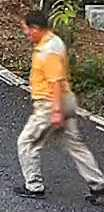

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黄,黄,黄
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


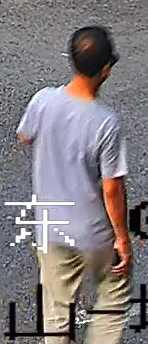

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黄,黄,黄
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


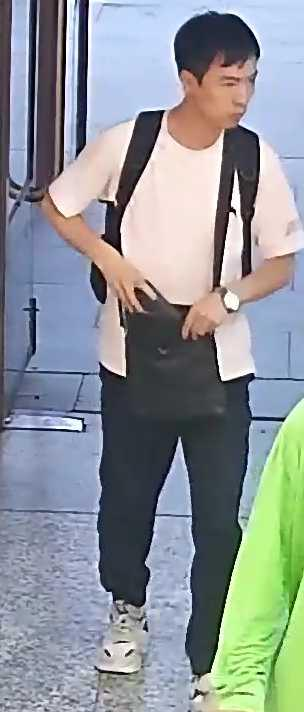

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


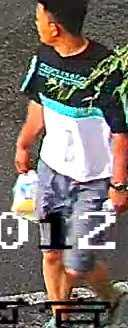

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,拎东西,拎东西,拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


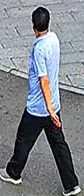

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,戴眼镜,未戴眼镜
拉杆箱,无,无,无


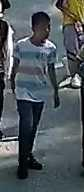

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


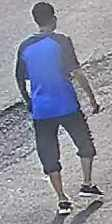

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,绿,绿,绿
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


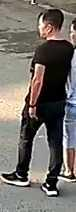

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未知,戴眼镜,戴眼镜
拉杆箱,无,无,无


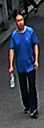

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


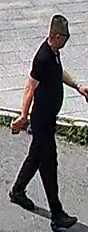

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


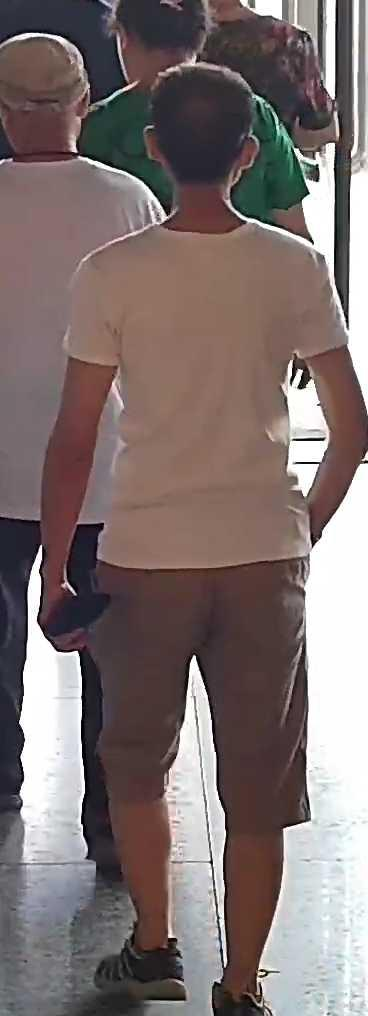

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黄,棕,棕
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未知,未知,未知
拉杆箱,无,无,无


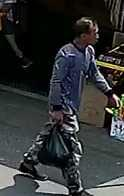

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,多色,黄,黄
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,戴眼镜,戴眼镜,戴眼镜
拉杆箱,无,无,无


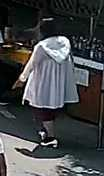

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,短裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,条纹,条纹,纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


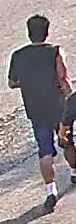

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


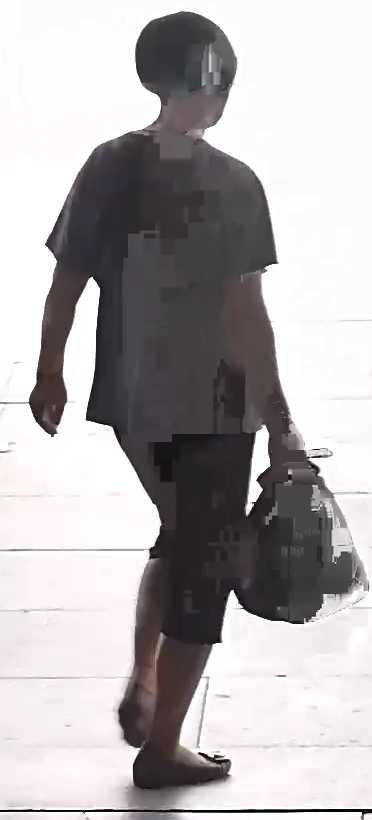

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


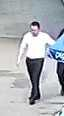

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


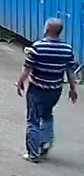

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,蓝
上衣纹理,条纹,条纹,条纹
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


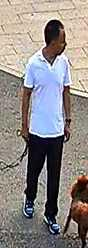

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


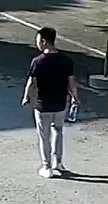

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,灰,白,白
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


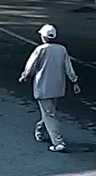

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,灰,灰,灰
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


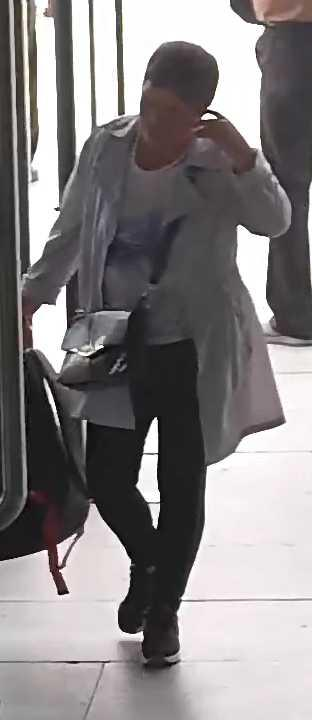

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未知,未知,未知
拉杆箱,无,无,无


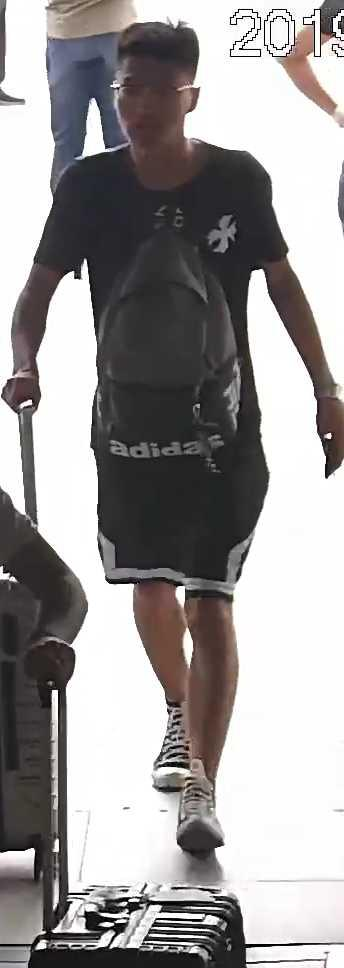

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,短裤,短裤,短裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝前,朝前,朝前
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


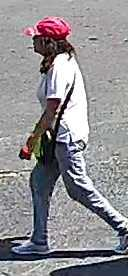

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,侧面,侧面,侧面
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


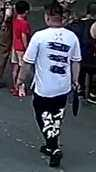

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,黑,黑,黑
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未知,未知,未知
拉杆箱,无,无,无


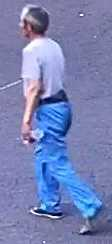

,resnet-1,resnet-2,resnet-3
行人类型,单人全身,单人全身,单人全身
裤子类型,长裤,长裤,长裤
裤子颜色,蓝,蓝,蓝
上衣纹理,纯色(logo),纯色(logo),纯色(logo)
朝向,朝后,朝后,朝后
打伞,未打伞,未打伞,未打伞
拎东西,未拎东西,未拎东西,未拎东西
口罩,未戴口罩,未戴口罩,未戴口罩
眼镜,未戴眼镜,未戴眼镜,未戴眼镜
拉杆箱,无,无,无


In [9]:
for path, annotation in att_prob.T.items():
    display( Image( filename =  path ))
    result = pd.concat([att.loc[path] for att in att_probs], axis=1)
    result.columns = ['resnet-1', 'resnet-2', 'resnet-3']
    display(result)

In [10]:
pd.DataFrame(([i.flatten() for i in temps]))

,0,1,2,3,4,5,6,7,8,9,...,150518,150519,150520,150521,150522,150523,150524,150525,150526,150527
0,-19.432362,24.317631,18.692631,13.067646,8.567631,5.192631,1.817631,1.880131,2.630131,3.380131,...,-26.824080,-40.199078,-48.449078,-53.824078,-44.824078,-35.824078,-23.074072,-6.574071,9.925921,-28.261572
1,-70.582878,-57.549717,-58.419613,-67.414505,-78.565018,-70.886444,-61.818848,-47.742321,-39.122425,-39.755070,...,1.515208,15.908069,29.654238,43.019032,25.614702,2.141482,13.291995,12.719287,-32.040913,-72.049843
2,-3.018299,49.423100,51.180912,52.938740,52.059834,48.544193,45.028584,39.462162,33.485600,28.739506,...,4.547022,6.011866,6.714991,5.425929,-5.824079,-17.074072,-21.117048,-17.952986,-14.788922,-46.781109
3,136.255127,136.255127,136.255127,136.255127,136.255127,136.255127,136.255127,136.255127,136.255127,136.255127,...,132.675919,132.675919,131.130951,36.929432,-12.540830,126.756104,129.112305,128.891251,128.675919,128.675919
4,-57.787918,-28.148327,-25.836941,-23.525555,-21.135975,-17.833996,-14.532017,-11.230038,-7.928066,-4.626087,...,22.418352,20.767366,19.116365,18.899141,18.899141,18.899141,20.723909,22.705111,24.686296,-22.523291
5,-16.903347,30.048649,36.738392,43.428135,43.985615,38.410816,32.836048,17.969990,1.245648,-13.186832,...,17.948244,18.443789,18.443789,18.443789,18.443789,18.443789,18.443789,18.443789,18.443789,-24.296171
6,-42.203419,-8.629436,-0.031223,0.241742,0.514698,0.787655,1.060612,1.333577,1.606533,1.879490,...,21.567507,22.795824,17.882555,12.969287,8.056033,1.095568,-6.547285,-14.190152,-26.950987,-55.065788
7,20.632053,58.371204,58.371204,58.371204,58.371204,58.371204,58.371204,58.371204,58.371204,58.371204,...,-75.324081,-75.324081,-75.324081,-75.324081,-75.324081,-75.324081,-75.324081,-75.324081,-75.324081,-84.538361
8,-9.682690,35.977390,51.878773,50.551456,49.224125,47.896793,47.286228,46.755299,46.224354,46.135883,...,57.865421,58.307865,58.573338,58.838779,58.944981,57.617649,56.290318,54.963001,37.185642,-9.005361
9,-64.583595,-43.732594,-34.391079,-33.662838,-35.219761,-51.584156,-66.626007,-74.410599,-76.034485,-67.211945,...,47.839420,48.358402,49.203831,50.241779,50.425938,50.425938,50.425938,50.425938,50.425938,12.758517


In [11]:
caffe_net2.infer_one_image('d/1.jpg') 

{'d/1.jpg': {'prob1': array([[4.6574787e-06, 9.9925297e-01, 5.2253625e-05, 1.7690750e-04,
          4.9123653e-05, 4.6411465e-04]], dtype=float32),
  'prob10': array([[3.4039471e-07, 2.1389194e-07, 9.9999511e-01, 1.1147932e-06,
          3.2210703e-06]], dtype=float32),
  'prob11': array([[3.4311373e-07, 1.7545457e-05, 1.1172467e-03, 4.1799885e-06,
          9.9534023e-01, 5.5192272e-06, 8.9837306e-07, 3.5058903e-03,
          4.6025857e-06, 2.7938131e-07, 1.1152681e-06, 2.1033120e-06]],
        dtype=float32),
  'prob12': array([[2.4072572e-06, 6.5223151e-04, 1.3690225e-04, 9.5288873e-01,
          4.6319731e-02]], dtype=float32),
  'prob13': array([[1.0204348e-04, 9.5690891e-02, 8.9050442e-01, 1.3702665e-02]],
        dtype=float32),
  'prob14': array([[2.8234112e-04, 2.3565728e-03, 9.9736100e-01]], dtype=float32),
  'prob15': array([[5.1315354e-05, 2.0877702e-07, 9.9994850e-01]], dtype=float32),
  'prob16': array([[0.02405372, 0.00380254, 0.97214377]], dtype=float32),
  'prob17': ar

In [12]:
caffe_net2.infer_one_image('d/1.jpg')['d/1.jpg']

{'prob1': array([[4.6574787e-06, 9.9925297e-01, 5.2253625e-05, 1.7690750e-04,
         4.9123653e-05, 4.6411465e-04]], dtype=float32),
 'prob10': array([[3.4039471e-07, 2.1389194e-07, 9.9999511e-01, 1.1147932e-06,
         3.2210703e-06]], dtype=float32),
 'prob11': array([[3.4311373e-07, 1.7545457e-05, 1.1172467e-03, 4.1799885e-06,
         9.9534023e-01, 5.5192272e-06, 8.9837306e-07, 3.5058903e-03,
         4.6025857e-06, 2.7938131e-07, 1.1152681e-06, 2.1033120e-06]],
       dtype=float32),
 'prob12': array([[2.4072572e-06, 6.5223151e-04, 1.3690225e-04, 9.5288873e-01,
         4.6319731e-02]], dtype=float32),
 'prob13': array([[1.0204348e-04, 9.5690891e-02, 8.9050442e-01, 1.3702665e-02]],
       dtype=float32),
 'prob14': array([[2.8234112e-04, 2.3565728e-03, 9.9736100e-01]], dtype=float32),
 'prob15': array([[5.1315354e-05, 2.0877702e-07, 9.9994850e-01]], dtype=float32),
 'prob16': array([[0.02405372, 0.00380254, 0.97214377]], dtype=float32),
 'prob17': array([[7.2138391e-02, 7.0892

In [13]:
# caffe_net1.infer_one_image('d/0_701664625_9.jpg')
caffe_net2.infer_one_image('d/7.jpg')

{'d/7.jpg': {'prob1': array([[1.0218489e-05, 9.9848312e-01, 9.6572439e-05, 3.8142048e-04,
          1.1765049e-04, 9.1098552e-04]], dtype=float32),
  'prob10': array([[4.5342489e-07, 2.1763908e-07, 9.9999392e-01, 7.4464111e-07,
          4.7079470e-06]], dtype=float32),
  'prob11': array([[5.9041315e-07, 3.8702303e-05, 1.0595748e-03, 7.4763916e-06,
          9.9037093e-01, 8.7747294e-06, 2.6611590e-06, 8.4960870e-03,
          6.5473155e-06, 5.3750301e-07, 1.8781284e-06, 6.3630864e-06]],
        dtype=float32),
  'prob12': array([[2.3276334e-06, 1.3461724e-03, 2.4871662e-04, 9.4123602e-01,
          5.7166714e-02]], dtype=float32),
  'prob13': array([[1.14356357e-04, 1.07415676e-01, 8.75639200e-01, 1.68307144e-02]],
        dtype=float32),
  'prob14': array([[3.7304350e-04, 2.5237992e-03, 9.9710315e-01]], dtype=float32),
  'prob15': array([[8.2655497e-05, 2.9422296e-07, 9.9991715e-01]], dtype=float32),
  'prob16': array([[0.07337157, 0.00657064, 0.9200577 ]], dtype=float32),
  'prob17'

# 比较编码有损压缩的影响

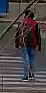

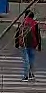

In [14]:
a = IMG_OPEN('d/1.jpg')
b = IMG_OPEN('d/7.jpg')
display( a, b )

In [15]:
pd.Series(np.array(a).flatten() == np.array(b).flatten()).describe()

count     12834
unique        2
top       False
freq       6848
dtype: object